---
**License**

 NC_CCL_mass_function

 Thu Apr 01 14:32:00 2021\
 Copyright  2021\
 Mariana Penna-Lima     <pennalima@gmail.com> \
 Cinthia Nunes de Lima  <cinthia.n.lima@uel.br>

---
---

 NC_CCL_mass_function\
 Copyright (C) 2021 Mariana Penna-Lima <pennalima@gmail.com>, Cinthia Nunes de Lima  <cinthia.n.lima@uel.br>

 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

## Importing the libraries

In the cell below we import the libraries <code>CCL</code> and <code>NumCosmo</code> for comparison between their mass functions for different multiplicity functions.

To the import <code>NumCosmo</code>, we should import <code>GObject</code> . This is important because <code>GObject</code> help us to maps the C language in other languages, like python.

The package <code>sys</code> is related to the manipulation and obtaining information from the python environment. Now, the packages <code>numpy</code> and <code>math</code> help us with the calculations, gives us access to mathematical functions.




In [1]:
# NumCosmo
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

# CCL
import pyccl as ccl

import sys 
import numpy as np 
import math 
import matplotlib.pyplot as plt 


## Cosmological constants

In this cell below we fix the cosmological constants to avoid conflits in the calculations and comparisons between the libraries.


$\Omega_{C}$ = 0.262 The density fraction at z=0 of CDM.<br>
$\Omega_{b}$ = 0.049 The density fraction at z=0 of baryons.<br>
$\Omega_{k}$ = 0.0 The curvature density fraction at z=0.<br>
$H_{0 }$ = 67.66   The Hubble constant.<br>
$Tcmb_{0}$  = 2.7255 The temperature at z=0 of CMB.<br>
$A_{s} = 2.1E-9$  The primordial normalization of the power spectrum at k=0.05 Mpc −1.<br>
$\sigma_{8}$ = 0.8277 The normalization of the power spectrum today. <br>
$n_{s}$ = 0.96 Scalar spectral index.<br>
$N_{eff}$ = 0.0 3.046 effective number of massless+massive neutrinos present at recombination.<br>
$\omega_{0}$ = -1.0 First order term of the dark energy equation of state.<br>
$\omega_{a}$ = 0.0 Second order term of the dark energy equation of state.<br>


In [2]:
Omega_c = 0.262 
Omega_b = 0.049 
Omega_k = 0.0 
H0      = 67.66  
Tcmb0   = 2.7255 
A_s     = 2.1e-9 
sigma8  = 0.8277 
n_s     = 0.96 
Neff    = 0.0 
w0      = -1.0 
wa      = 0.0 


## Initializing the libraries 

First we create the cosmology object  of CCL, <code>cosmo_ccl</code>.Next, we initialize the <code>NumCosmo</code> using <code>Ncm.cfg_init ()</code>, this function should be placed before any NumCosmo function, and then we create the cosmology object of <code>NumCosmo</code>.

We also create the homogeneous and isotropic object, <code> hiprim </code>, this is necessary to calculate the linear power spectrum P(k).





In [3]:
# CCL Cosmology
cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, Neff=Neff,
                          h=H0/100.0, sigma8=sigma8, n_s=n_s, Omega_k=Omega_k,
                          w0=w0, wa=wa, T_CMB=Tcmb0, m_nu=[0.00, 0.0, 0.0], 
                          transfer_function='eisenstein_hu', matter_power_spectrum='linear')


Ncm.cfg_init () 
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

# NumCosmo Cosmology
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDECpl{'massnu-length':<0>}")
cosmo.omega_x2omega_k ()
cosmo.param_set_by_name ("H0",        H0)
cosmo.param_set_by_name ("Omegak",    Omega_k)
cosmo.param_set_by_name ("w0",        w0)
cosmo.param_set_by_name ("w1",        wa)
cosmo.param_set_by_name ("Omegab",    Omega_b)
cosmo.param_set_by_name ("Omegac",    Omega_c)
cosmo.param_set_by_name ("Tgamma0",   Tcmb0)
#cosmo.param_set_by_name ("massnu_0",  0.06)
#cosmo.param_set_by_name ("ENnu", 3.046 - 3.0 * cosmo.E2Press_mnu (1.0e10) / (cosmo.E2Omega_g (1.0e10) * (7.0/8.0*(4.0/11.0)**(4.0/3.0))))
 
hiprim = Nc.HIPrimPowerLaw.new ()
hiprim.param_set_by_name ("ln10e10ASA", math.log (1.0e10 * A_s))
hiprim.param_set_by_name ("n_SA",       n_s)
 

cosmo.add_submodel (hiprim)
    
dist = Nc.Distance.new (3.0)
dist.prepare (cosmo)
  
# dir(ccl.Cosmology)
#help(ccl.Cosmology)

## Linear matter power spectrum

The linear matter power spectrum P(k) describes the linear evolution of the density pertubations. To calculate it we use the transfer function T(k) and apply a tophat filter.

The code <code> TransferFunc.new_from_name </code> returns a new <code>NcTransferFunc</code>, whose type is defined in this case by "NcTransferFuncEH" .
    
The transfer function, T(k), is defined as,
$$
T(k)\equiv \frac{\hat{\delta}(k,z=0)}{\hat{\delta}(k,z=\infty)} \frac {\hat{\delta}(k=0,z=\infty)}{\hat{\delta}(k=0,z=0)}
$$

$\hat{\delta}(k,z) $ is the density pertubation and, by definition, $\lim_{k\rightarrow 0} T (k) \rightarrow 1$.

We create a new linear matter power spectrum object using <code> PowspecMLTransfer.new (tf)</code> calculated over a range of small to large scales of the wavenumber,k, and apply a tophat filter using <code> Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT) </code>.

In [4]:
tf = Nc.TransferFunc.new_from_name ("NcTransferFuncEH")

#
# New linear matter power spectrum object based of the EH transfer function.
psml = Nc.PowspecMLTransfer.new (tf)
psml.require_kmin (1.0e-3)
psml.require_kmax (1.0e3)

#
# Apply a tophat filter to the psml object, set best output interval.
psf = Ncm.PowspecFilter.new (psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0 ()


## Multiplicity functions

The multiplicity function contains the information about the collapse process and halo formation. In the cell above we  defined the multiplicity functions objects for different formalisms.

In [5]:
# CCL multiplicity functions

# Press & Schechter mass function
ccl_hmf_PS = ccl.halos.MassFuncPress74(cosmo_ccl)

# Sheth & Tormen mass function
ccl_hmf_ST = ccl.halos.MassFuncSheth99(cosmo_ccl)

# Jenkins 2001 mass function
ccl_hmf_Jenkins = ccl.halos.MassFuncJenkins01(cosmo_ccl)

# Tinker 2008 mass function
ccl_hmf_T08 = ccl.halos.MassFuncTinker08(cosmo_ccl)

# Tinker 2010 mass function
ccl_hmf_T10 = ccl.halos.MassFuncTinker10(cosmo_ccl)

# NumCosmo multiplicity functions

# Press & Schechter 
hmf_PS = Nc.MultiplicityFunc.new_from_name ("NcMultiplicityFuncPS")

# Sheth & Tormen
hmf_ST = Nc.MultiplicityFunc.new_from_name ("NcMultiplicityFuncST")

# Jenkins
hmf_Jenkins = Nc.MultiplicityFunc.new_from_name ("NcMultiplicityFuncJenkins")

# Tinker 2008 (mean density - mass definition)
hmf_TM08 = Nc.MultiplicityFunc.new_from_name ("NcMultiplicityFuncTinkerMean")

# Tinker 2010
hmf_T10 = Nc.MultiplicityFunc.new_from_name ("NcMultiplicityFuncTinkerMeanNormalized")

#
# New mass function object using the objects defined above.
#
mf_PS      = Nc.HaloMassFunction.new (dist, psf, hmf_PS)
mf_ST      = Nc.HaloMassFunction.new (dist, psf, hmf_ST)
mf_Jenkins = Nc.HaloMassFunction.new (dist, psf, hmf_Jenkins)
mf_TM08    = Nc.HaloMassFunction.new (dist, psf, hmf_TM08)
mf_T10     = Nc.HaloMassFunction.new (dist, psf, hmf_T10)


In [6]:
# Array of masses
m_arr = np.geomspace(1E10,1E15,128)

# Array of redshifts
z_arr = np.linspace(0.0,1.0,16)

In [7]:
psf.prepare (cosmo)
sigma8_nc = psf.eval_sigma (0.0, 8.0 / 0.6766)

mf_PS.set_eval_limits (cosmo, math.log (1e10), math.log(1e16), 0.0, 2.0)
mf_PS.prepare (cosmo)
mf_ST.set_eval_limits (cosmo, math.log (1e10), math.log(1e16), 0.0, 2.0)
mf_ST.prepare (cosmo)
mf_Jenkins.set_eval_limits (cosmo, math.log (1e10), math.log(1e16), 0.0, 2.0)
mf_Jenkins.prepare (cosmo)
mf_TM08.set_eval_limits (cosmo, math.log (1e10), math.log(1e16), 0.0, 2.0)
mf_TM08.prepare (cosmo)
mf_T10.set_eval_limits (cosmo, math.log (1e10), math.log(1e16), 0.0, 2.0)
mf_T10.prepare (cosmo)

In [8]:
def cmp_double (desc, m1, m2, x1, x2):
    print ("%s: %s = % 22.15g, %s = % 22.15g, CMP: %9.2e" % (desc, m1, x1, m2, x2, math.fabs (x1 / x2 - 1.0)))


## Mass function and plot

In the cell below we created a list <code> multiplicity_functions </code> of pairs, containing the multiplicity function of <code> ccl </code> and <code> numcosmo </code>, respectively, for each formalism. Then we use the multiplicity functions to calculate the mass function in each case.

For the ccl the code is:

<code>ccl_mf = ccl_mf_obj.get_mass_function (cosmo_ccl, m_arr, 1.0)</code>

<code>ccl_nm = m_arr * ccl_mf </code>

For the NumCosmo is:

<code>nc_mf = [nc_mf_obj.dn_dlnM (cosmo, logm, 0.0) * math.log(10.0) for logm in np.log(m_arr)]</code>

<code>nc_nm = m_arr * nc_mf </code>

We plot first the graph of mass functions calculated using datas of ccl and the second graph plotted is the difference of the mass function of libraries, for each formalism.


<Figure size 432x288 with 0 Axes>

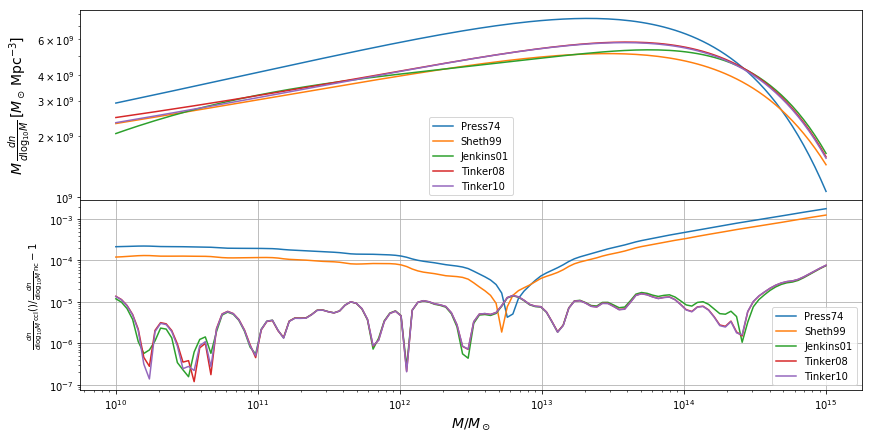

In [9]:
plt.figure()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(14,7))

multiplicity_functions = [(ccl_hmf_PS, mf_PS), (ccl_hmf_ST, mf_ST), (ccl_hmf_Jenkins, mf_Jenkins), (ccl_hmf_T08, mf_TM08), (ccl_hmf_T10, mf_T10)]
for ccl_mf_obj, nc_mf_obj in multiplicity_functions:
    ccl_mf = ccl_mf_obj.get_mass_function (cosmo_ccl, m_arr, 1.0)
    ccl_nm = m_arr * ccl_mf
    axs[0].plot(m_arr, ccl_nm, label = ccl_mf_obj.name)
    
    nc_mf = [nc_mf_obj.dn_dlnM (cosmo, logm, 0.0) * math.log(10.0) for logm in np.log(m_arr)]
    nc_nm = m_arr * nc_mf
    
    axs[1].plot (m_arr, np.abs (ccl_nm / nc_nm  - 1.0), '-', label = ccl_mf_obj.name)
    

#Plot settings
axs[0].set_xscale ('log')
axs[0].set_yscale ('log')
#axs[0].ylim([1.0E9,8.5E9])
axs[1].set_yscale ('log')
axs[1].set_xlabel(r'$M/M_\odot$', fontsize=14)
axs[0].set_ylabel(r'$M\,\frac{dn}{d\log_{10}M}\,[M_\odot\,{\rm Mpc}^{-3}]$',
           fontsize=14)
axs[1].set_ylabel(r'$\frac{dn}{d\log_{10}M}_{\mathrm{ccl}} () / \frac{dn}{d\log_{10}M}_{\mathrm{nc}} - 1$')
axs[0].legend(loc='best')

axs[1].legend(loc='best')
axs[1].grid()


plt.show ()

In [11]:
print(hmf_PS.delta_c)

1.686
